In [1]:
import numpy as np
import time
import pickle
import matplotlib.pyplot as plt
import OneBlockFit
from generative_model_utils import event_dict_to_aggregated_adjacency, event_dict_to_adjacency
from spectral_clustering import *
from MultiBlockFit_Hessian import fit_kernel_sum_model, fit_n_r_br_gr_fixed_beta_model, print_paramters_kernel


In [6]:
n_classes = 5
timestamp_max = 1000
kernel = "single"
# kernel = "sum"
beta = 1
betas = np.array([0.02, 0.2, 2, 20])


def create_incident_event_dict(dnx_pickle_file_name, timestamp_max=1000):
    incident_dnx = pickle.load(open(dnx_pickle_file_name, 'rb'))
    event_dict = {}

    timestamp_first = incident_dnx.edges()[0][2]
    timestamp_last = incident_dnx.edges()[-1][2]
    duration = timestamp_last - timestamp_first

    if timestamp_max is None:
        timestamp_max = timestamp_last - timestamp_first

    node_set = set(incident_dnx.nodes())
    node_id_map, id_node_map = get_node_id_maps(node_set)

    for edge in incident_dnx.edges():
        sender_id = node_id_map[edge[0]]
        receiver_id = node_id_map[edge[1]]
        timestamp = (edge[2] - timestamp_first) / duration * timestamp_max
        if timestamp < 0:
            print(edge)

        if (sender_id, receiver_id) not in event_dict:
            event_dict[(sender_id, receiver_id)] = []

        event_dict[(sender_id, receiver_id)].append(timestamp)

    return event_dict, len(incident_dnx.nodes()), duration, id_node_map


def get_node_id_maps(node_set):
    nodes = list(node_set)
    nodes.sort()

    node_id_map = {}
    id_node_map = {}
    for i, n in enumerate(nodes):
        node_id_map[n] = i
        id_node_map[i] = n

    return node_id_map, id_node_map

In [7]:
dnx_pickle_file_name = 'incident_impulse.pckl'
events_dict, n_nodes, duration, id_node_map = create_incident_event_dict(
    dnx_pickle_file_name, timestamp_max)

agg_adj = event_dict_to_aggregated_adjacency(n_nodes, events_dict)
unweight_adj = event_dict_to_adjacency(n_nodes, events_dict)
node_membership = spectral_cluster(agg_adj,n_classes,n_kmeans_init=100)
                              

In [9]:
print(np.histogram(node_membership, bins=n_classes))
for i in range(n_classes):
    print(f"Class {i}")
    nodes_in_class_i = np.where(node_membership == i)[0]
    for id in nodes_in_class_i:
        print(id_node_map[id], end=' ')
    print()

(array([41, 32, 18, 38, 27]), array([0. , 0.8, 1.6, 2.4, 3.2, 4. ]))
Class 0
ALB ANG AUL BAH BEL BOS BUL CAN CEN CRO CZR DEN ERI FRN GHA GMY HUN ICE IRN ITA JOR KUW LUX MAC MNG NAM NOR NTH OMA POL POR QAT ROM RUM SAU SEN SPN TUN TUR UAE UKG 
Class 1
AUS AZE BHU BUI COL CON COS DRV EST FIN GRG HON INS IRE JPN KOS LAT LIT MLD PER PHI PNG ROK SIN SLO SLV SWD TAW TRI UKR VTM ZAM 
Class 2
ARG BOT CDI CHL CYP DJI GAM GNB GRC IRQ LIB MOR SAL SYR TOG YEM YUG ZIM 
Class 3
AFG BEN BLZ CAM CAO CHA DOM EGY ETH GUA GUI GUY HAI IND ISR KEN LBR LEB LES MAA MAL MYA MZM NIG NIR PAN RWA SAF SIE SOM SSD SUD SWA SWZ THI UGA USA VEN 
Class 4
ALG ARM BLR BNG BRA CHN CUB DRC ECU EQG JAM KYR KZK MLI NEP NIC PAK PAL PRK RUS SOL SRI SUR TAJ TAZ TKM UZB 


In [10]:
params_est, ll, n_events = fit_kernel_sum_model(
    events_dict, node_membership, n_classes, timestamp_max, betas)
mu_bp, alpha_n_bp, alpha_r_bp, alpha_br_bp, alpha_gr_bp, C_bp_list, betas = params_est

Text(0.5, 1.0, 'alpha_gr')

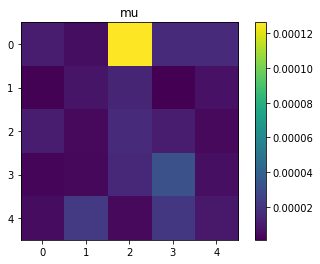

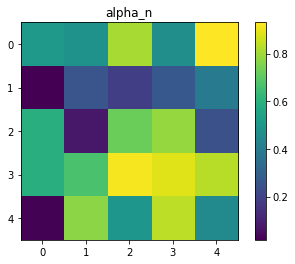

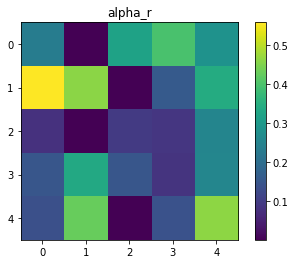

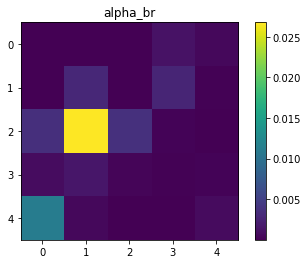

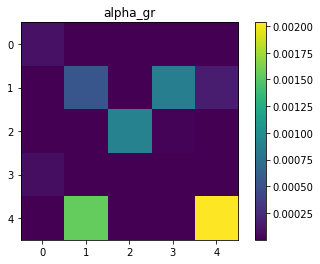

In [11]:

C_bp = np.zeros((n_classes, n_classes, np.size(betas)))
raveled_index = 0
for i in range(n_classes):
    for j in range(n_classes):
        C_bp[i, j, :] = C_bp_list[raveled_index]
        raveled_index += 1

scaling_betas = np.sum(C_bp / betas, 2)

#print_paramters_6(params_est)

#%% Plot parameters
plt.figure()
plt.imshow(mu_bp)
plt.colorbar()
plt.title("mu")

plt.figure()
plt.imshow(alpha_n_bp * scaling_betas)
plt.colorbar()
plt.title("alpha_n")

plt.figure()
plt.imshow(alpha_r_bp * scaling_betas)
plt.colorbar()
plt.title("alpha_r")

plt.figure()
plt.imshow(alpha_br_bp * scaling_betas)
plt.colorbar()
plt.title("alpha_br")

plt.figure()
plt.imshow(alpha_gr_bp * scaling_betas)
plt.colorbar()
plt.title("alpha_gr")

In [30]:
## Refinement
for (i, j) in events_dict:
    events_dict[(i,j)] = np.array(events_dict[(i,j)])

re_com = refinement_sum_of_kernel(params_tuple, events_dict, node_membership, n_classes,
                             timestamp_max)
new_params_tuple, new_ll, n_events= fit_kernel_sum_model(events_dict, re_com, n_classes,
                                                                timestamp_max, betas)

In [18]:
new_ll

-18659.427214473275

In [19]:
ll

-18982.74182602486

In [20]:
print(np.histogram(re_com, bins=n_classes))
for i in range(n_classes):
    print(f"Class {i}")
    nodes_in_class_i = np.where(re_com == i)[0]
    for id in nodes_in_class_i:
        print(id_node_map[id], end=' ')
    print()

(array([41, 55,  6, 22, 32]), array([0. , 0.8, 1.6, 2.4, 3.2, 4. ]))
Class 0
ALB ANG AUL BAH BEL BOT BUL CAN CRO DEN ERI FRN GHA GMY GRC GUI HUN ICE IRE IRN ITA JOR LUX MAC MOR NAM NOR NTH OMA POR QAT ROM RUM SAU SEN SPN TUN TUR UAE UKG YEM 
Class 1
ALG ARG AUS AZE BEN BHU BLR BNG BRA BUI CHL COL CON COS CZR DRV EGY EQG EST FIN GAM GRG GUA GUY HON INS JAM JPN LAT LES LIT MAA MLD MNG MZM NIR PAL PAN PER PHI PNG POL ROK SAL SIN SLO SLV SOL SWD SWZ TAW TRI UKR VTM ZAM 
Class 2
BOS HAI IRQ LIB SYR YUG 
Class 3
AFG CAM CDI CEN CHA DJI ETH IND ISR KOS KUW LBR LEB MLI NIG RWA SIE SOM SUD UGA USA ZIM 
Class 4
ARM BLZ CAO CHN CUB CYP DOM DRC ECU GNB KEN KYR KZK MAL MYA NEP NIC PAK PRK RUS SAF SRI SSD SUR SWA TAJ TAZ THI TKM TOG UZB VEN 
